In [8]:
## import des fonctions 
import functions as f
import time
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
import pickle 
import time
import os

# pour l'info sur la date d'entrainement du modèle
from datetime import datetime
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
import re

import psutil
from psutil._common import bytes2human

from datetime import date
from dateutil.relativedelta import relativedelta

# Feature importance gain
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 10,10

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


### DATA IMPORTATION

In [82]:
data = pd.read_csv('data_input.csv')
df = data.copy()
display(df.shape)
display(df.columns)
df.head()

(7043, 21)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [83]:
# Conversion de la target en binaire
df['Churn'] = df['Churn'].map({'Yes':1,'No':0},na_action=None)

#Removing the customerID column
df.drop(columns='customerID', inplace=True)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [84]:
#Checking for duplicate values
df.duplicated().sum()

22

In [85]:
#Removing the duplicate values
df.drop_duplicates(inplace=True)

In [20]:
#Checking the datatypes of the columns
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

In [86]:
# Convert 'TotalCharges'
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [87]:
#Checking for null values
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [88]:
#Droping the null values
df.dropna(inplace=True)

### EXPLORATORY DATA ANALYSIS

In [9]:
features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

### Univariate analysis

#### Subscriber profiles

Text(0.5, 1.0, 'Dependents')

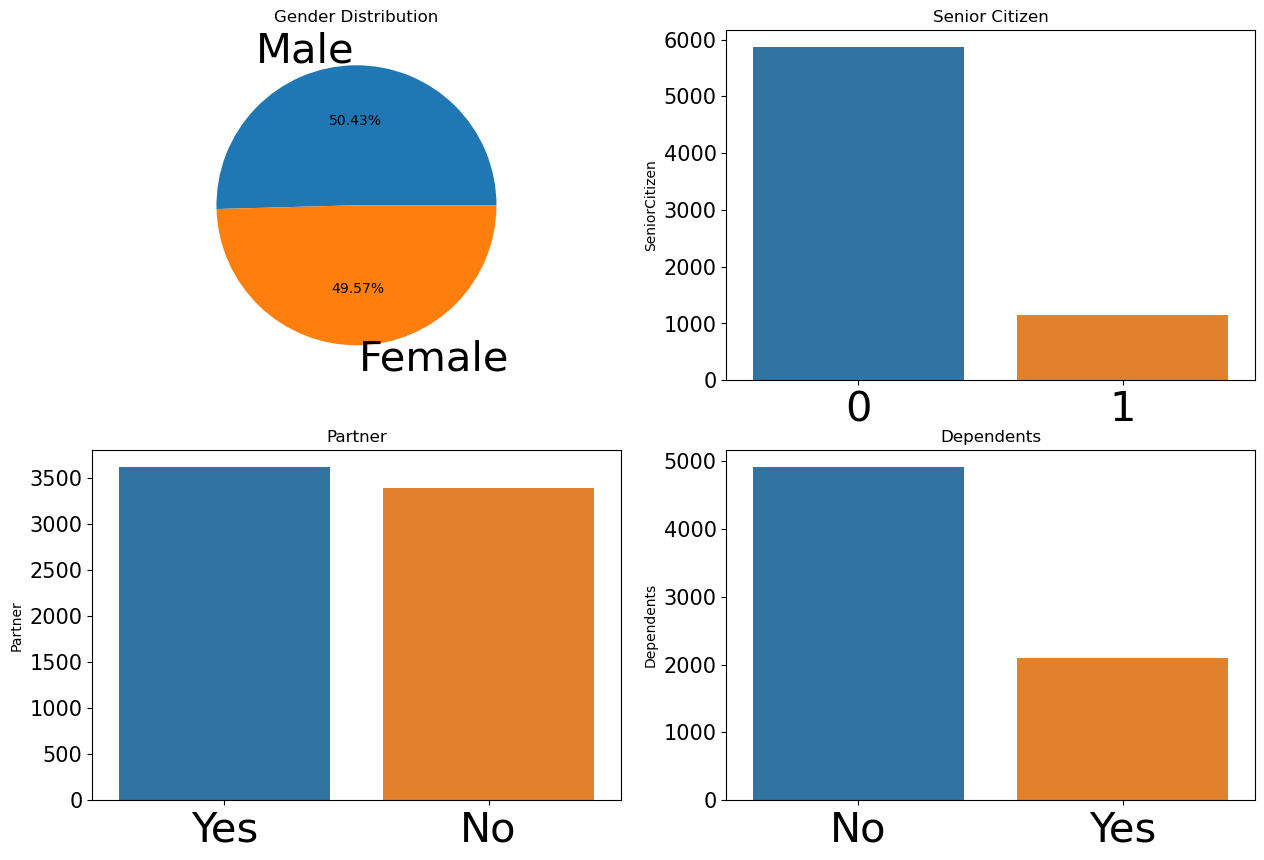

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

#Gender Distribution
ax[0,0].pie(df['gender'].value_counts(), labels  = ['Male', 'Female'], autopct = '%1.2f%%')
ax[0,0].set_title('Gender Distribution')

#Senior Citizen Distribution
sns.barplot(y = df['SeniorCitizen'].value_counts(), x = df['SeniorCitizen'].unique(), ax=ax[0,1]).set_title('Senior Citizen')

#Partner Distribution
sns.barplot(y = df['Partner'].value_counts(), x = df['Partner'].unique(), ax=ax[1,0]).set_title('Partner')

#Dependents Distribution
sns.barplot(y = df['Dependents'].value_counts(), x = df['Dependents'].unique(), ax=ax[1,1]).set_title('Dependents')

These graphs shows the customer demographics. The number of males and females is almost same, with few more males than females in the dataset. Majority of them are not senior citizen. Nearly 3500, customers have a partner and similar number of cutomers don't. Majority of the customers don't have dependents, but still a significant number does have dependents.

From these graphs, we get know about the customers demographics, which help us to get an idea of their psychology based on their age, relationship status, and dependents.

#### Services

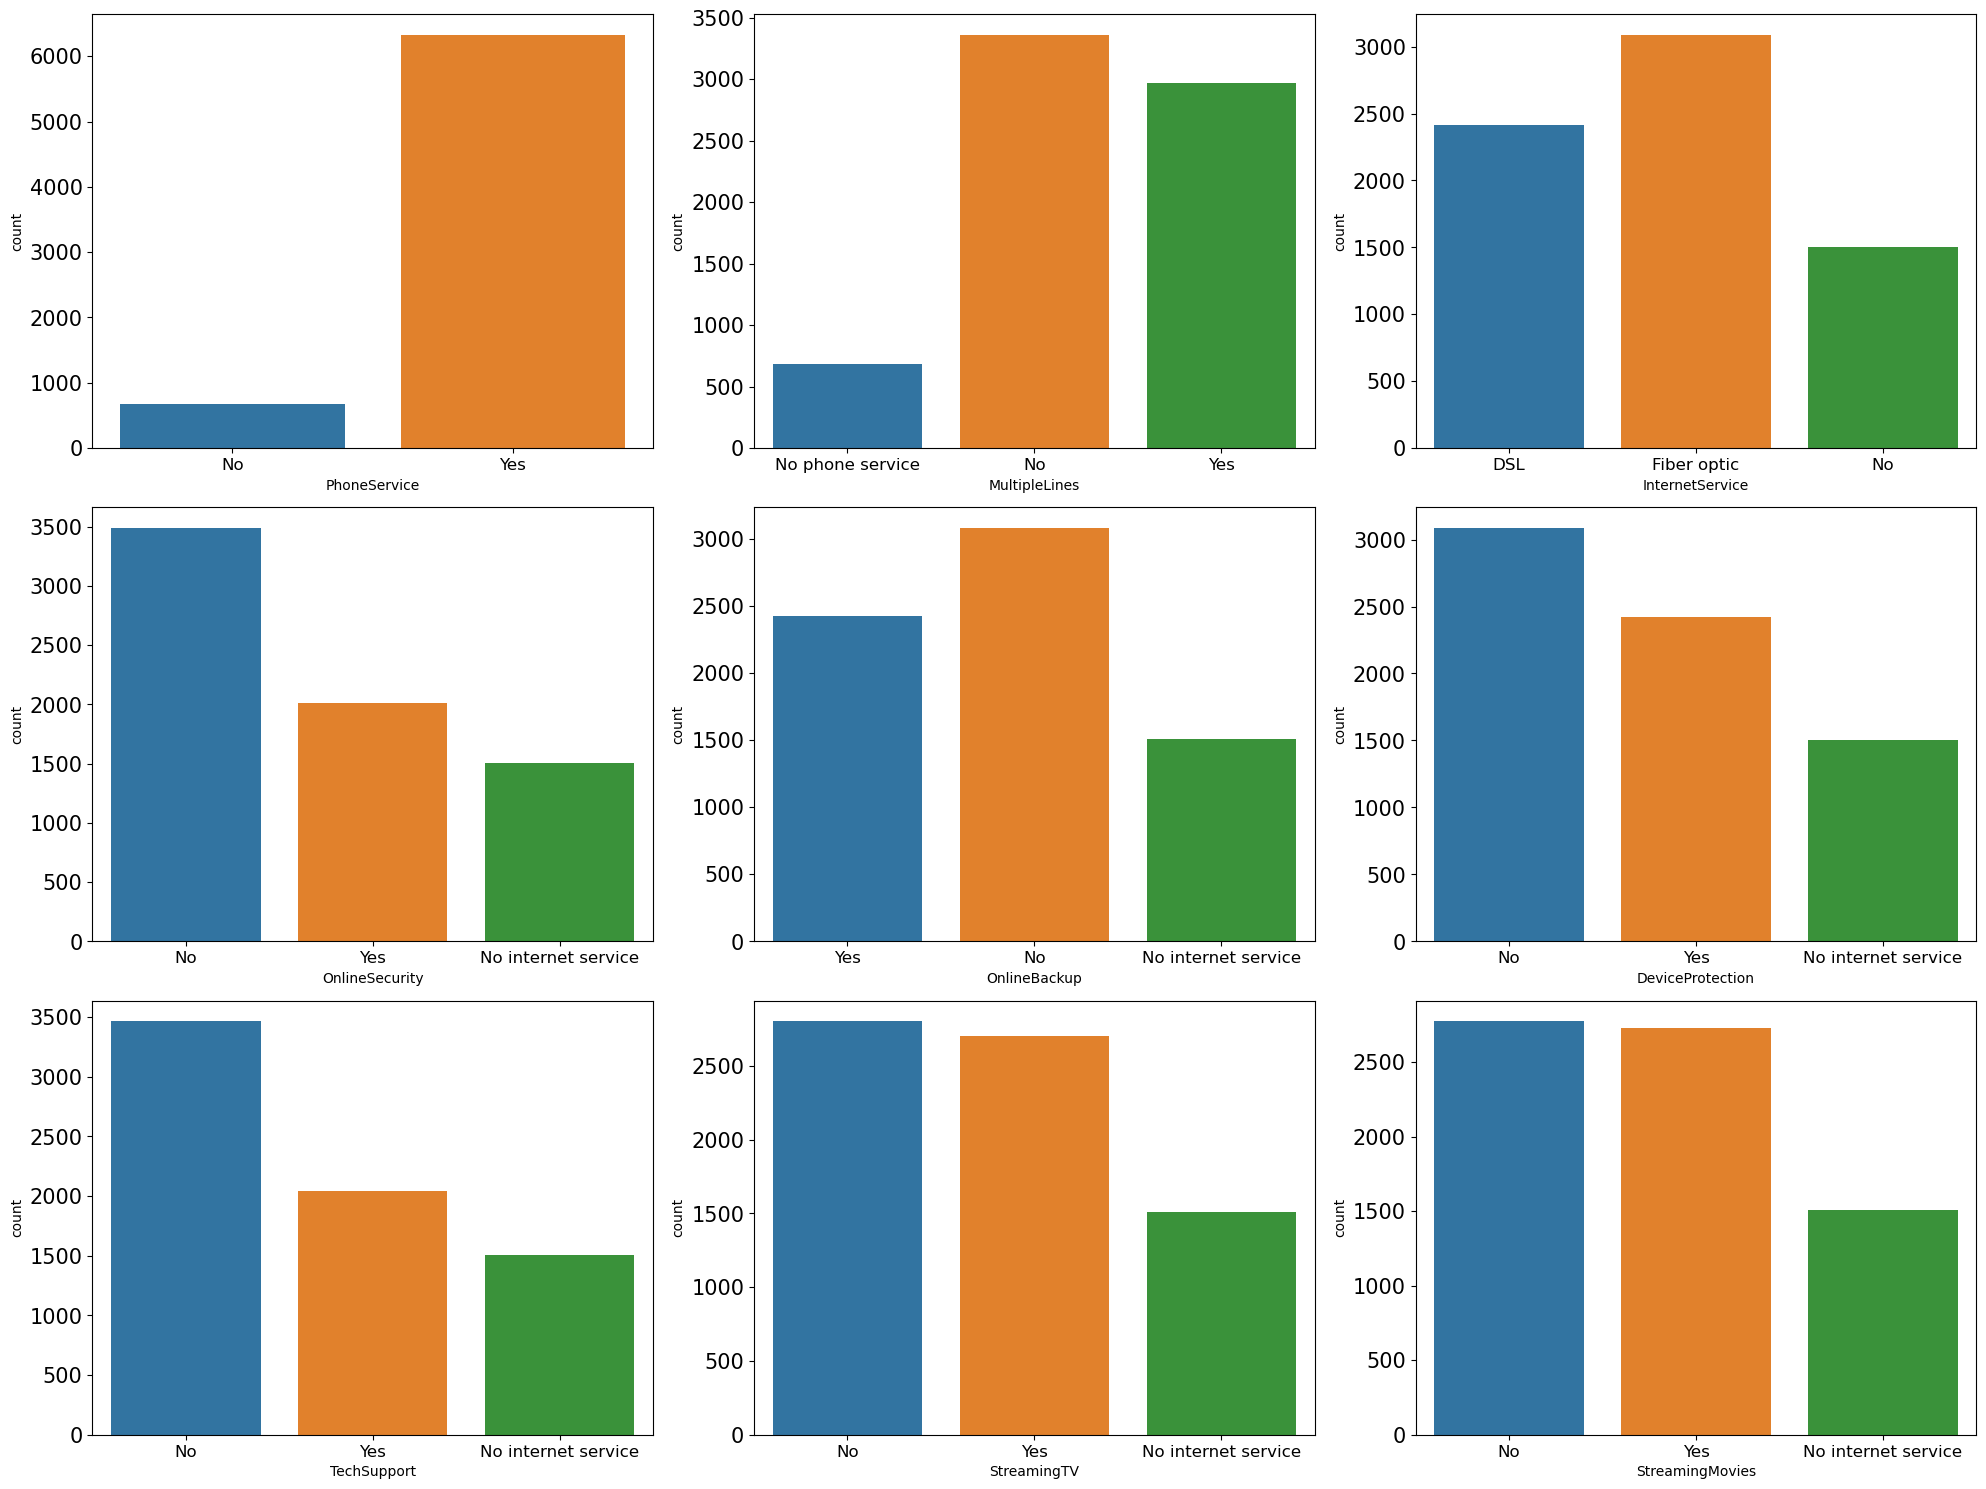

In [31]:
# List of columns to visualize
services_to_plot = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                   'StreamingMovies']

# Calculate the number of rows and columns needed
num_features = len(services_to_plot)
num_cols = 3
num_rows = (num_features // num_cols) + (num_features % num_cols)

# Create a grid of subplots
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

# Use a loop to create the subplots
for i, column in enumerate(services_to_plot):
    row_index = i // num_cols
    col_index = i % num_cols
    
    sns.countplot(x=df[column], ax=ax[row_index, col_index])

    # Decrease the font size of x-axis labels
    ax[row_index, col_index].tick_params(axis='x', labelsize=12)

# Adjust layout to avoid empty spaces
plt.tight_layout()
plt.show()

#### Tenure and Contract

Text(0.5, 1.0, 'Contract Type')

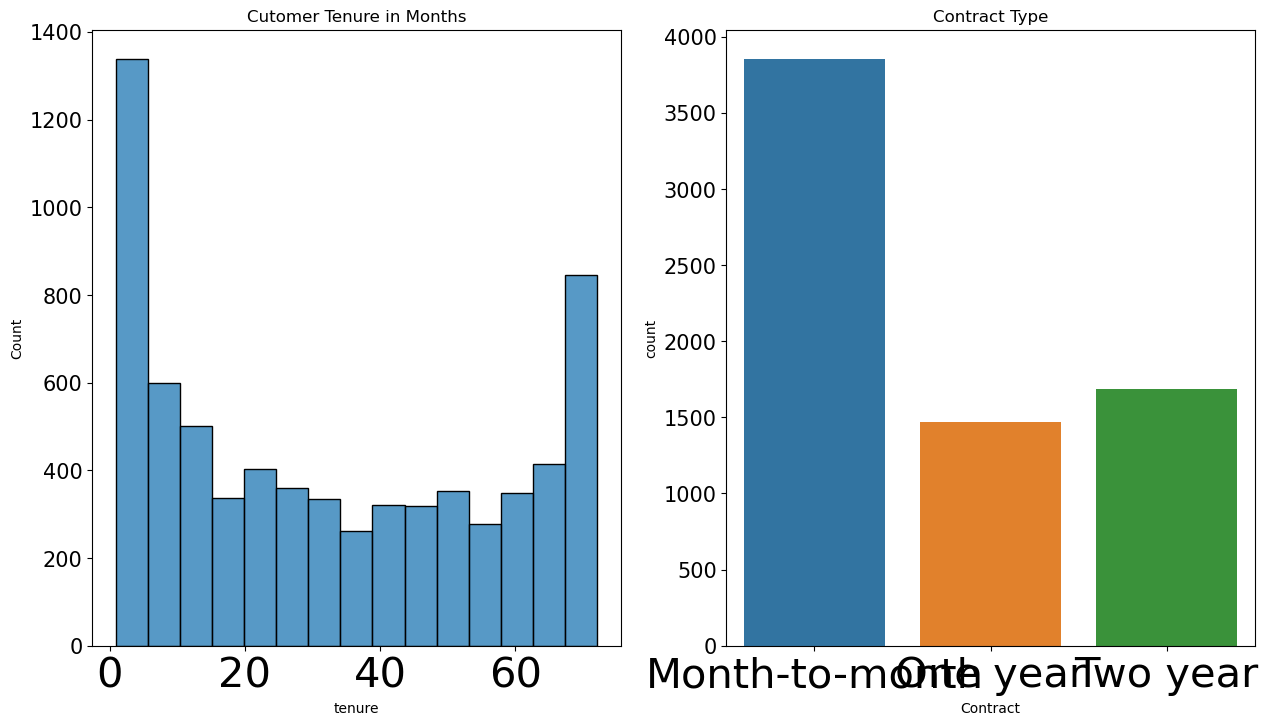

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.histplot(x = 'tenure', data = df, ax= ax[0]).set_title('Cutomer Tenure in Months')
sns.countplot(x = 'Contract', data = df, ax= ax[1]).set_title('Contract Type')

#### Billing and Charges

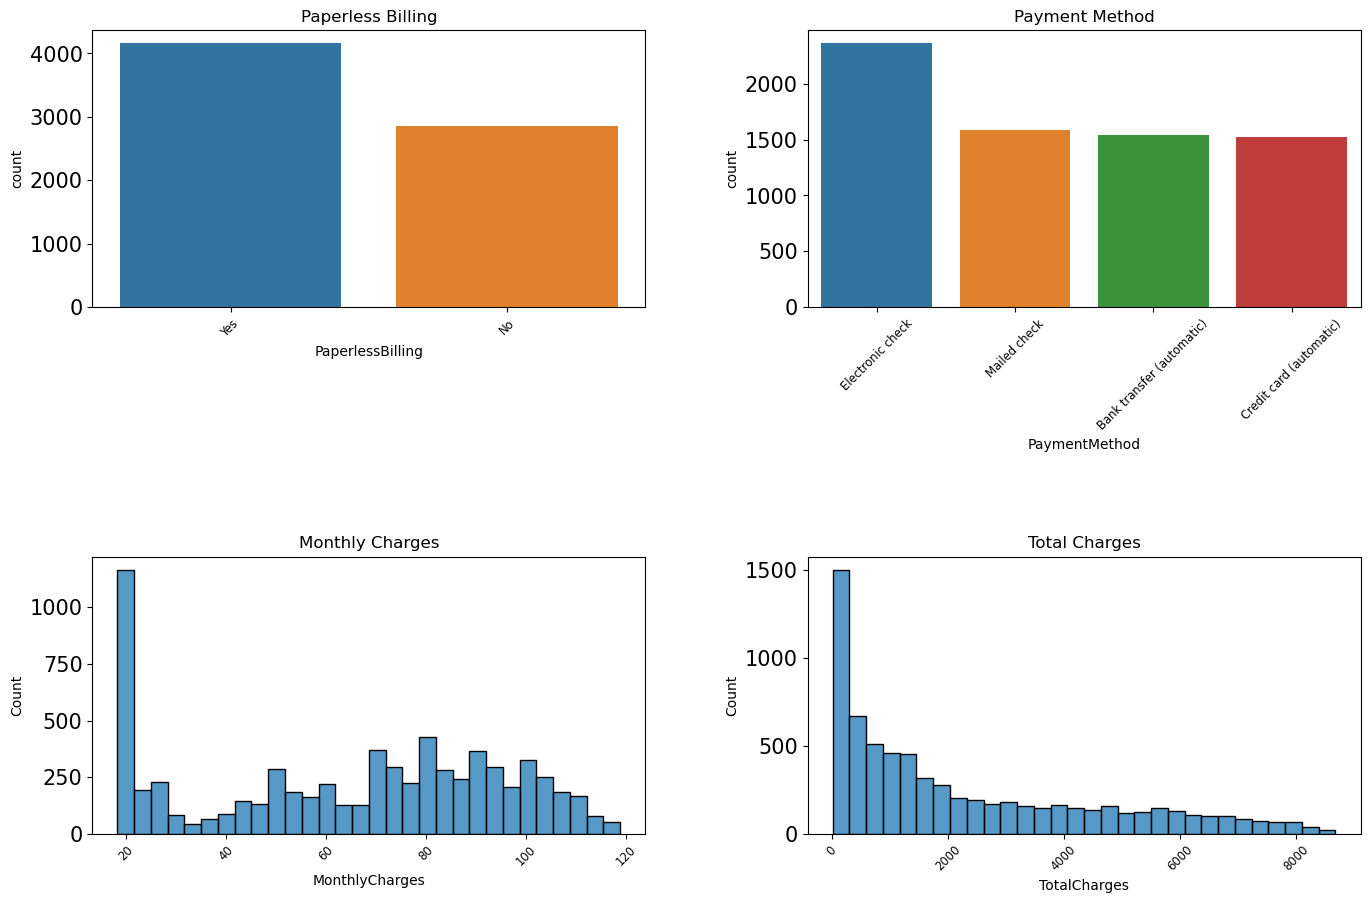

In [36]:
# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout(pad=5.0)

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.9)

# Paperless billing
sns.countplot(x=df['PaperlessBilling'], ax=ax[0, 0]).set_title('Paperless Billing')
ax[0, 0].tick_params(axis='x', rotation=45, labelsize='small')  # Adjust x-axis labels rotation and font size

# Payment Method
sns.countplot(x=df['PaymentMethod'], ax=ax[0, 1]).set_title('Payment Method')
ax[0, 1].tick_params(axis='x', rotation=45, labelsize='small')  # Adjust x-axis labels rotation and font size

# Monthly Charges
sns.histplot(x='MonthlyCharges', data=df, ax=ax[1, 0], bins=30).set_title('Monthly Charges')
ax[1, 0].tick_params(axis='x', rotation=45, labelsize='small')  # Adjust x-axis labels rotation and font size

# Total Charges
sns.histplot(x='TotalCharges', data=df, ax=ax[1, 1], bins=30).set_title('Total Charges')
ax[1, 1].tick_params(axis='x', rotation=45, labelsize='small')  # Adjust x-axis labels rotation and font size

# Display the plot
plt.show()

#### Churn count

Text(0.5, 1.0, 'Churn Count')

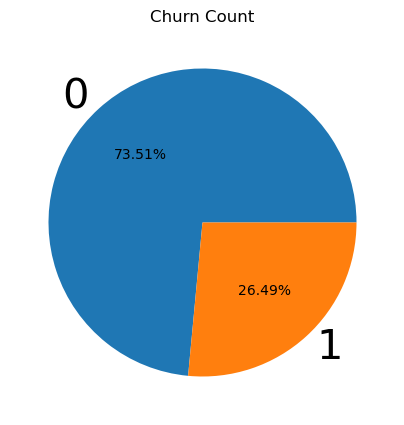

In [47]:
plt.figure(figsize=(5, 5)) # Set the figure size
plt.pie(x = df['Churn'].value_counts(), labels = df['Churn'].unique(), autopct = '%1.2f%%')
plt.title('Churn Count')

### Bivariate analysis

#### Analysis according to 'Churn'

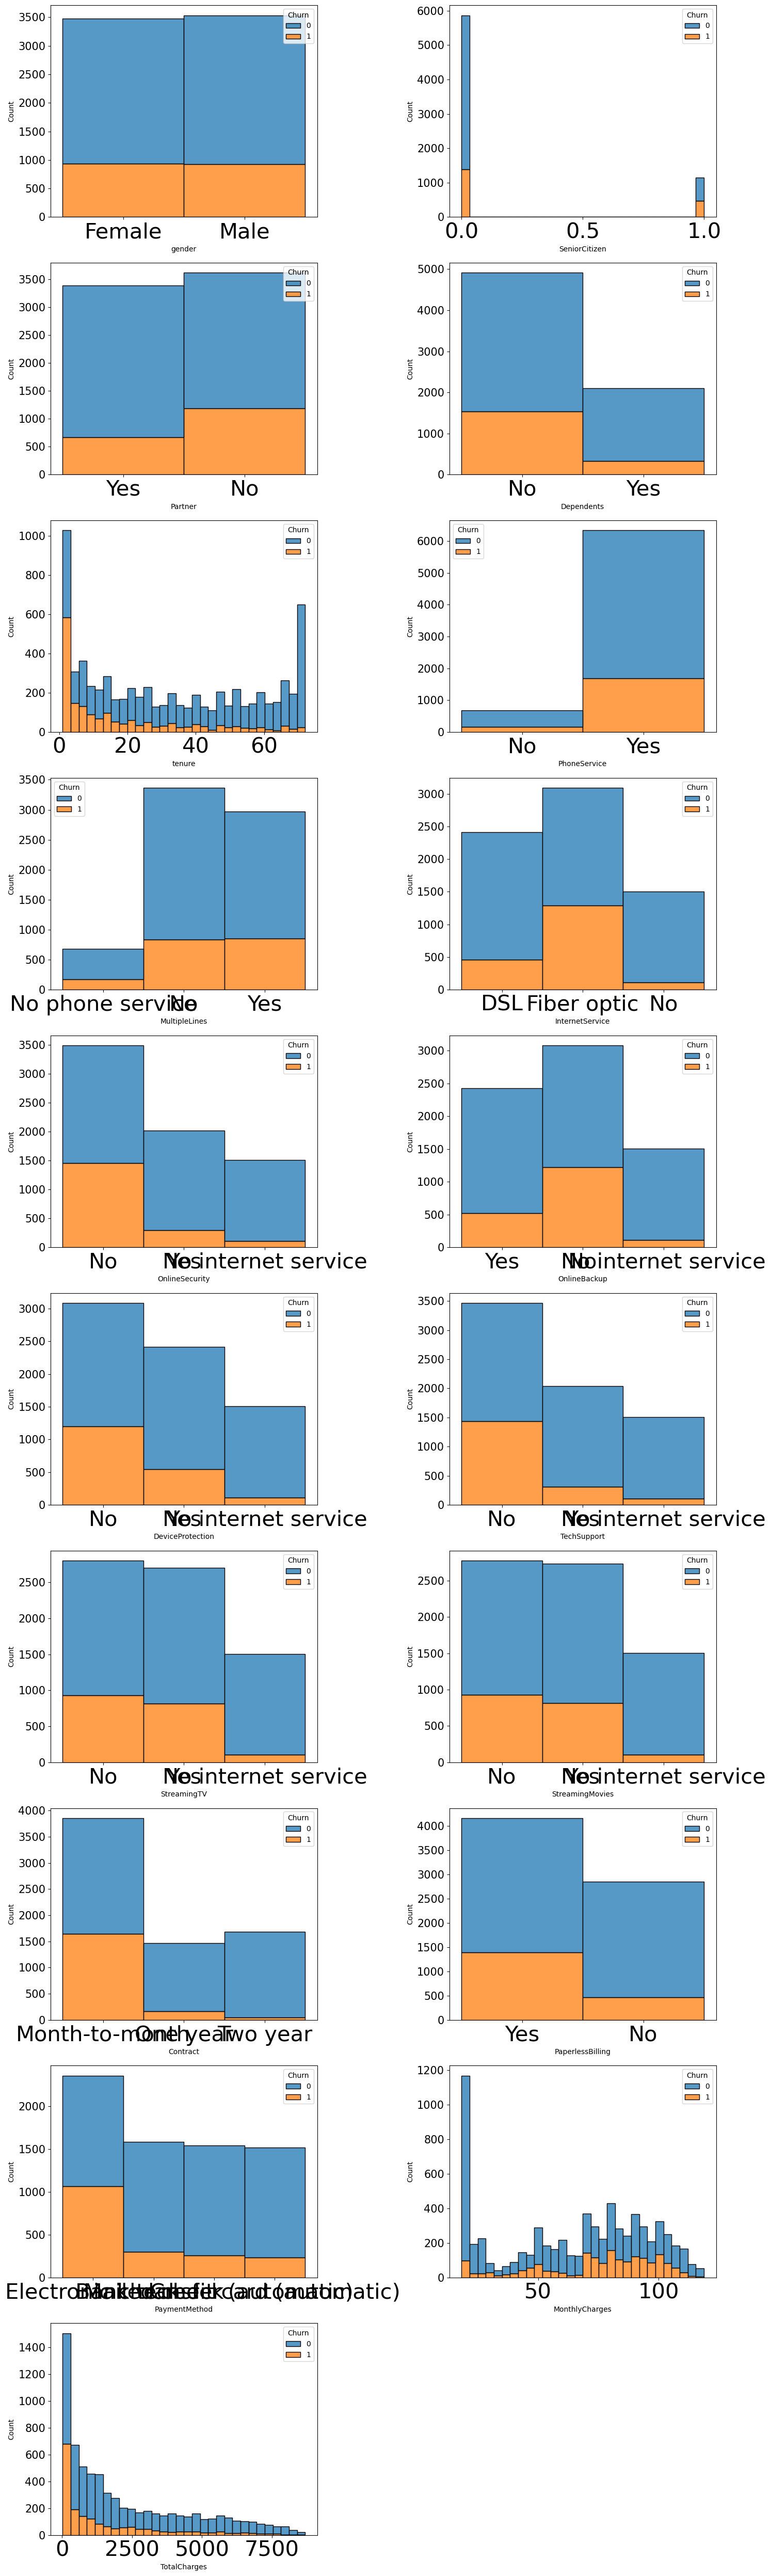

In [39]:
# Histograms

num_rows = (len(features) // 2) + (len(features) % 2) 
plt.figure(figsize=(15, 5 * num_rows))

for i, feature in enumerate(features):
    plt.subplot(num_rows, 2, i + 1)
    sns.histplot(data=df, x=feature, hue='Churn', multiple='stack', bins=30)
    #plt.title(f'Distribution de {feature} par Churn')

plt.tight_layout()
plt.show()

### Correlation analysis

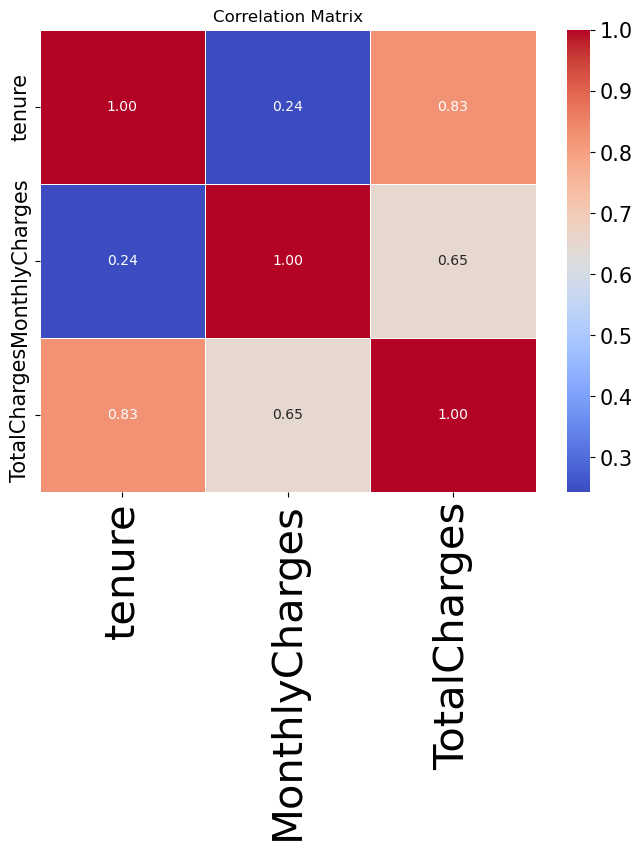

In [48]:
# Selecting only numerical features for correlation analysis
numerical_features = df[['tenure', 'MonthlyCharges', 'TotalCharges']]

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Data processing

#### Features engineering

In [92]:
# Tenure Binning
tenure_bins = [0, 12, 24, 36, 48, 60, float('inf')]
tenure_labels = ['0-12', '13-24', '25-36', '37-48', '49-60', '60+']
df['TenureGroup'] = pd.cut(df['tenure'], bins=tenure_bins, labels=tenure_labels, right=False)

In [93]:
# Feature Scaling
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [94]:
# Binary Encoding
binary_features = ['gender', 'Partner', 'Dependents', 'PhoneService']
df[binary_features] = df[binary_features].replace({'Yes': 1, 'No': 0, 'Male':0,'Female':1})

In [95]:
# One-Hot Encoding
categorical_features = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                         'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                         'Contract', 'PaperlessBilling', 'PaymentMethod','TenureGroup']
df = pd.get_dummies(df, columns=categorical_features)

In [96]:
# Combine Multiple Features
df['MonthlyToTotalRatio'] = df['MonthlyCharges'] / df['TotalCharges']

In [97]:
# Family Size
df['FamilySize'] = df['Partner'] + df['Dependents']

In [98]:
df.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                     float64
PhoneService                                 int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet service           uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                              uint8
OnlineBackup_No internet servic

#### Features selection

In [69]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [99]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

In [100]:
# Use SelectKBest to select the best features
k_best = 10  # Choose the number of best features to select
selector = SelectKBest(score_func=f_classif, k=k_best)
X_new = selector.fit_transform(X, y)

In [101]:
# Get the indices of the best features
feature_indices = selector.get_support(indices=True)

# Get the names of the best features
best_features = X.columns[feature_indices]

# Display the best features
print("Selected Best Features:")
print(best_features)

Selected Best Features:
Index(['tenure', 'InternetService_Fiber optic', 'OnlineSecurity_No',
       'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No',
       'Contract_Month-to-month', 'Contract_Two year',
       'PaymentMethod_Electronic check', 'TenureGroup_0-12'],
      dtype='object')


### Machine Learning

#### First training

In [102]:
# Split the data into features and target
X = df[best_features]
y = df['Churn']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc, roc_auc_score

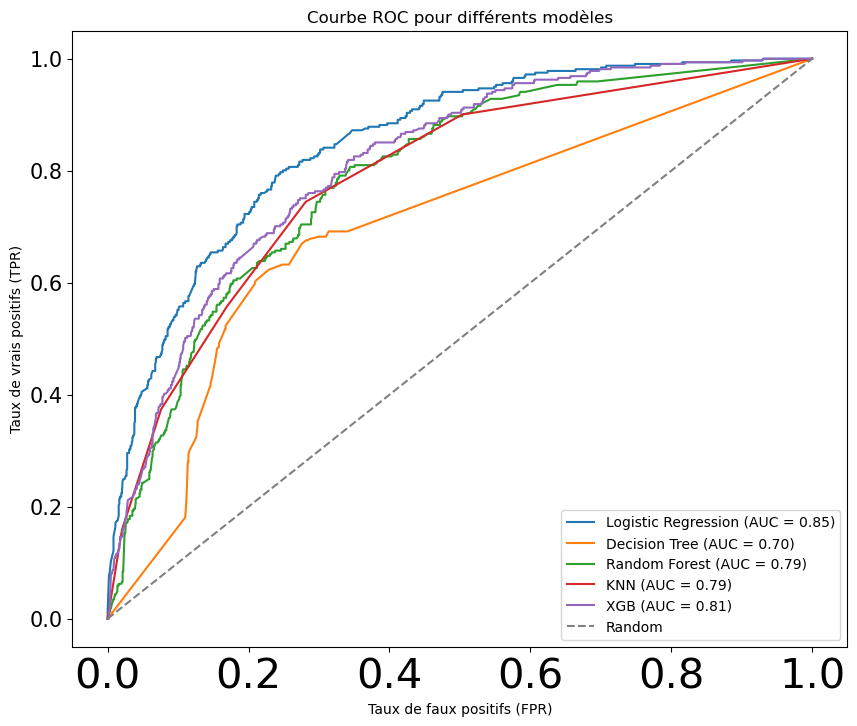

In [107]:
# Initialisation des modèles
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGB': XGBClassifier()
}

# Entraînement des modèles et construction des courbes ROC
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Calcul du score AUC
    auc_score = roc_auc_score(y_test, y_prob)

    # Tracé de la courbe ROC
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

# Tracé de la ligne en diagonale (référence)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Ajout de labels et de la légende
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC pour différents modèles')
plt.legend()

# Affichage du graphe
plt.show()

#### Hyperparameter optimisation 

In [108]:
from sklearn.model_selection import GridSearchCV

##### Logistic regression

In [140]:
penalty = ['l1', 'l2']
C =[0.001, 0.01, 0.1, 1, 10, 100]
params = dict(penalty=penalty, C=C)

In [141]:
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=params,
    scoring = 'roc_auc',
    cv = 3,
    verbose=True
)

In [142]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\Ivan Reganha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ivan Reganha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ivan Reganha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Ivan Reganha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solve

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=True)

In [144]:
best_log = grid_search.best_estimator_.fit(X_train, y_train)

##### XGB

In [135]:
max_depth = [4,8,16]
n_estimators = [250,500,100]
learning_rate = [0.005, 0.05, 0.5]

params = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)

In [136]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [137]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring = 'roc_auc',
    cv = 3,
    verbose=True
)

In [138]:
grid_search.fit(X_train, y_train,eval_set=[(X_train,y_train)])

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[0]	validation_0-logloss:0.69104
[1]	validation_0-logloss:0.68896
[2]	validation_0-logloss:0.68691
[3]	validation_0-logloss:0.68486
[4]	validation_0-logloss:0.68285
[5]	validation_0-logloss:0.68086
[6]	validation_0-logloss:0.67888
[7]	validation_0-logloss:0.67692
[8]	validation_0-logloss:0.67498
[9]	validation_0-logloss:0.67307
[10]	validation_0-logloss:0.67116
[11]	validation_0-logloss:0.66928
[12]	validation_0-logloss:0.66742
[13]	validation_0-logloss:0.66556
[14]	validation_0-logloss:0.66373
[15]	validation_0-logloss:0.66191
[16]	validation_0-logloss:0.66012


[17]	validation_0-logloss:0.65832
[18]	validation_0-logloss:0.65657
[19]	validation_0-logloss:0.65482
[20]	validation_0-logloss:0.65308
[21]	validation_0-logloss:0.65137
[22]	validation_0-logloss:0.64967
[23]	validation_0-logloss:0.64799
[24]	validation_0-logloss:0.64631
[25]	validation_0-logloss:0.64467
[26]	validation_0-logloss:0.64303
[27]	validation_0-logloss:0.64141
[28]	validation_0-logloss:0.63981
[29]	validation_0-logloss:0.63820
[30]	validation_0-logloss:0.63663
[31]	validation_0-logloss:0.63506
[32]	validation_0-logloss:0.63351
[33]	validation_0-logloss:0.63196
[34]	validation_0-logloss:0.63044
[35]	validation_0-logloss:0.62893
[36]	validation_0-logloss:0.62744
[37]	validation_0-logloss:0.62594
[38]	validation_0-logloss:0.62446
[39]	validation_0-logloss:0.62301
[40]	validation_0-logloss:0.62156
[41]	validation_0-logloss:0.62012
[42]	validation_0-logloss:0.61869
[43]	validation_0-logloss:0.61728
[44]	validation_0-logloss:0.61588
[45]	validation_0-logloss:0.61449
[46]	validatio

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=Non

In [139]:
best_xgb = grid_search.best_estimator_.fit(X_train, y_train,eval_set=[(X_train,y_train)], early_stopping_rounds = 100)

[0]	validation_0-logloss:0.69098
[1]	validation_0-logloss:0.68884
[2]	validation_0-logloss:0.68672
[3]	validation_0-logloss:0.68462
[4]	validation_0-logloss:0.68254
[5]	validation_0-logloss:0.68048
[6]	validation_0-logloss:0.67845
[7]	validation_0-logloss:0.67643
[8]	validation_0-logloss:0.67443
[9]	validation_0-logloss:0.67245
[10]	validation_0-logloss:0.67049
[11]	validation_0-logloss:0.66855
[12]	validation_0-logloss:0.66662
[13]	validation_0-logloss:0.66472
[14]	validation_0-logloss:0.66283
[15]	validation_0-logloss:0.66096
[16]	validation_0-logloss:0.65911
[17]	validation_0-logloss:0.65727
[18]	validation_0-logloss:0.65546


[19]	validation_0-logloss:0.65366
[20]	validation_0-logloss:0.65187
[21]	validation_0-logloss:0.65010


c:\Users\Ivan Reganha\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-logloss:0.64835
[23]	validation_0-logloss:0.64662
[24]	validation_0-logloss:0.64489
[25]	validation_0-logloss:0.64321
[26]	validation_0-logloss:0.64154
[27]	validation_0-logloss:0.63989
[28]	validation_0-logloss:0.63826
[29]	validation_0-logloss:0.63663
[30]	validation_0-logloss:0.63502
[31]	validation_0-logloss:0.63343
[32]	validation_0-logloss:0.63185
[33]	validation_0-logloss:0.63029
[34]	validation_0-logloss:0.62871
[35]	validation_0-logloss:0.62717
[36]	validation_0-logloss:0.62565
[37]	validation_0-logloss:0.62413
[38]	validation_0-logloss:0.62264
[39]	validation_0-logloss:0.62115
[40]	validation_0-logloss:0.61968
[41]	validation_0-logloss:0.61822
[42]	validation_0-logloss:0.61678
[43]	validation_0-logloss:0.61534
[44]	validation_0-logloss:0.61393
[45]	validation_0-logloss:0.61252
[46]	validation_0-logloss:0.61112
[47]	validation_0-logloss:0.60974
[48]	validation_0-logloss:0.60836
[49]	validation_0-logloss:0.60700
[50]	validation_0-logloss:0.60566
[51]	validatio

#### Evaluation

In [125]:
from sklearn.metrics import confusion_matrix, classification_report,precision_recall_fscore_support

Classification Report - Log:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1081
           1       0.65      0.50      0.56       321

    accuracy                           0.82      1402
   macro avg       0.75      0.71      0.73      1402
weighted avg       0.81      0.82      0.81      1402


Classification Report - XGB:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1081
           1       0.62      0.55      0.58       321

    accuracy                           0.82      1402
   macro avg       0.75      0.72      0.73      1402
weighted avg       0.81      0.82      0.82      1402



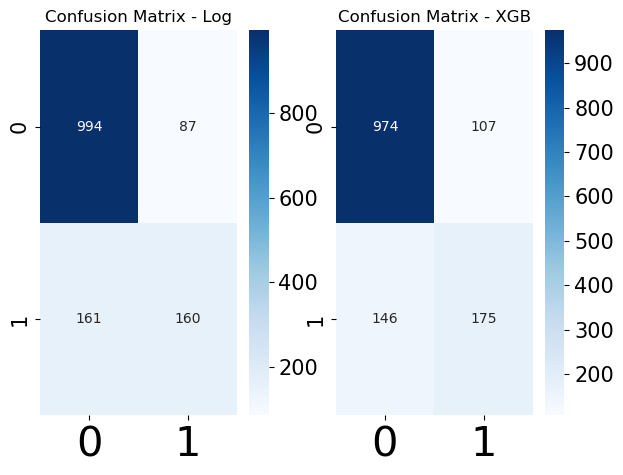

In [145]:
# Predict on the test set with the best models
y_pred_log = best_log.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

# Confusion matrix for model 1
conf_matrix_model1 = confusion_matrix(y_test, y_pred_log)

# Confusion matrix for model 2
conf_matrix_model2 = confusion_matrix(y_test, y_pred_xgb)

# Create a subplot
fig, axes = plt.subplots(1, 2, figsize=(7, 5))

# Show confusion matrices
sns.heatmap(conf_matrix_model1, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title('Confusion Matrix - Log')

sns.heatmap(conf_matrix_model2, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title('Confusion Matrix - XGB')

# Show classification reports
report_model1 = classification_report(y_test, y_pred_log)
print("Classification Report - Log:")
print(report_model1)

report_model2 = classification_report(y_test, y_pred_xgb)
print("\nClassification Report - XGB:")
print(report_model2)


### Features Importance

In [151]:
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [154]:
model = best_xgb
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

Text(0.5, 1.0, 'XGB Classifier Feature Importance')

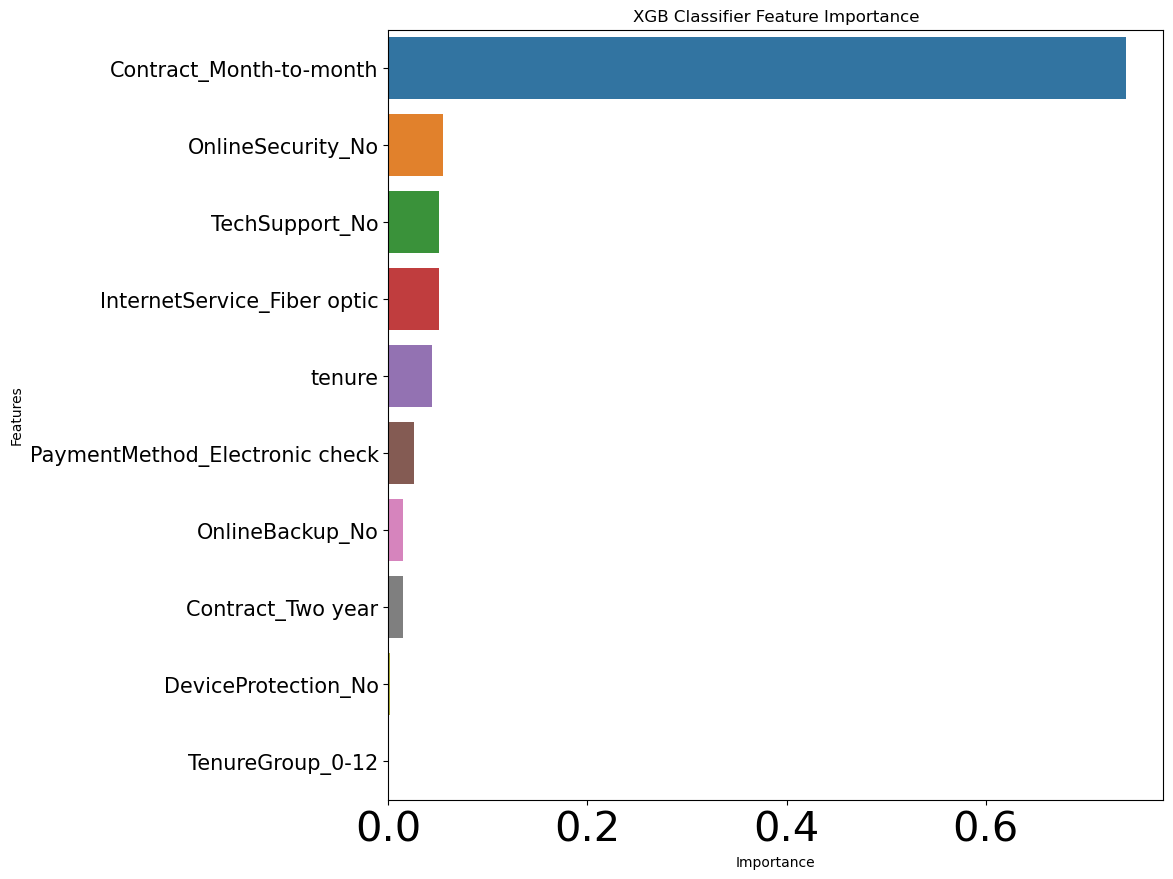

In [153]:
# Decision Tree Classifier Feature Importance
feature_df = pd.DataFrame({'Features': best_features, 'Importance': model.feature_importances_})
feature_df.sort_values('Importance', ascending=False, inplace=True)
sns.barplot(x = 'Importance', y = 'Features', data = feature_df).set_title('XGB Classifier Feature Importance')